<a href="https://colab.research.google.com/github/AxelGautrand/Digitalization-in-Sports/blob/main/StatsBomb_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output

In [3]:
!pip install statsbombpy
clear_output()

In [4]:
!pip install mplsoccer
clear_output()

In [5]:
dataset = "/content/drive/My Drive/DIS/Colab/open-data/data/"

In [6]:
from statsbombpy import sb
import pandas as pd
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.patches import Ellipse
from matplotlib.colorbar import constrained_layout
import matplotlib.patheffects as path_effects
from mplsoccer.pitch import Pitch
from shapely.geometry import Polygon as shapelyPolygon
from scipy.stats import norm
from collections import Counter, defaultdict

In [7]:
from google.colab import data_table
data_table.enable_dataframe_formatter()  # For tables with lines

In [8]:
!pwd
writePath = "drive/My Drive/DIS/Write"
%cd $writePath
clear_output()

# Create JSON

In [9]:
class CreateEvent360():
    def __init__(self):
        self.competitionId = 53
        self.seasonId = 106
        self.fmt = "dict"
        self.matchInfo = self.get_all_matches_info()
        self.matchId = list(self.matchInfo.keys())
        self.matchEvents = dict(zip(self.matchId, list(map(self.get_all_events_from_match, self.matchId))))
        self.matchFrames = dict(zip(self.matchId, list(map(self.get_all_360_frames_from_match, self.matchId))))
        self.matchEventLocations = dict(zip(self.matchId, list(map(self.get_event_id_matching_360_events, self.matchId))))

        for iMatchId in self.matchId:
            self.fill_event_frame_location_details(iMatchId)
            self.exportJson(iMatchId)


    def get_all_matches_info(self):
        return sb.matches(competition_id=self.competitionId, season_id=self.seasonId, fmt=self.fmt)

    def get_all_events_from_match(self, matchId):
        return sb.events(matchId, fmt=self.fmt)

    def get_all_360_frames_from_match(self, matchId):
        return sb.frames(matchId, fmt=self.fmt)

    def get_event_id_matching_360_events(self, matchId):
        eventsIds = [self.matchFrames[matchId][iEventIndex]['event_uuid'] for iEventIndex in
                     range(len(self.matchFrames[matchId]))]
        #return dict(zip(eventsIds, len(eventsIds) * [{'possession': None, 'eventLoc': None, 'homeLoc': list(), 'awayLoc': list()}]))
        return {x: {'possession': None, 'eventLoc': None, 'homeLoc': list(), 'awayLoc': list()} for x in eventsIds}

    def fill_event_frame_location_details(self, matchId):
        for iEventIndex in range(len(self.matchFrames[matchId])):
            iEvent = self.matchFrames[matchId][iEventIndex]['event_uuid']
            if 'location' in self.matchEvents[matchId][iEvent].keys():
                self.matchEventLocations[matchId][iEvent]['eventLoc'] = self.matchEvents[matchId][iEvent]['location']
            if 'period' in self.matchEvents[matchId][iEvent].keys():
                self.matchEventLocations[matchId][iEvent]['period'] = self.matchEvents[matchId][iEvent]['period']
            possessionId = self.matchEvents[matchId][iEvent]['possession_team']['id']
            if possessionId == self.matchInfo[matchId]['home_team']['home_team_id']:
                possession = 'home'
            else:
                possession = 'away'
            self.matchEventLocations[matchId][iEvent]['possession'] = possession
            for iPlayer in self.matchFrames[matchId][iEventIndex]['freeze_frame']:
                if possession == 'home':
                    if iPlayer['teammate']:
                        self.matchEventLocations[matchId][iEvent]['homeLoc'].append(iPlayer['location'])
                    else:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                elif possession == 'away':
                    if iPlayer['teammate']:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                    else:
                        self.matchEventLocations[matchId][iEvent]['awayLoc'].append(iPlayer['location'])
                        
    def exportJson(self, matchId):
          fileName = str(matchId) + '.json'
          with open(fileName, 'w') as fh:
              json.dump(self.matchEventLocations[matchId], fh)
          fh.close()

In [10]:
# Only once
event360 = CreateEvent360()
clear_output()

In [11]:
def loadJson(matchId):
    filename = str(matchId) + '.json'
    with open(filename, 'r') as fh:
        matchData = json.load(fh)
    fh.close()
    return matchData

In [12]:
matchIDs = [int(iFile.split('.')[0]) for iFile in os.listdir(os.getcwd()) if 'json' in iFile and iFile.split('.')[0].isnumeric()]

In [13]:
allMatchData = {iMatchId: loadJson(iMatchId) for iMatchId in matchIDs}

# Pitch and Area calculations

In [14]:
def createPitch(length,width, unity,linecolor): # in meters
    # Code by @JPJ_dejong

    """
    creates a plot in which the 'length' is the length of the pitch (goal to goal).
    And 'width' is the width of the pitch (sideline to sideline). 
    Fill in the unity in meters or in yards.
    """
    #Set unity
    if unity == "meters":
        # Set boundaries
        if length >= 120.5 or width >= 75.5:
            return(str("Field dimensions are too big for meters as unity, didn't you mean yards as unity?\
                       Otherwise the maximum length is 120 meters and the maximum width is 75 meters. Please try again"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
            plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
            plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)
            
            #Left 5-meters Box
            plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
            plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)
            
            #Right 5 -eters Box
            plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
            plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
            plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)
            
            #Prepare Circles
            centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
            rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
            #Axis titles

    #check unity again
    elif unity == "yards":
        #check boundaries again
        if length <= 95:
            return(str("Didn't you mean meters as unity?"))
        elif length >= 131 or width >= 101:
            return(str("Field dimensions are too big. Maximum length is 130, maximum width is 100"))
        #Run program if unity and boundaries are accepted
        else:
            #Create figure
            fig=plt.figure()
            #fig.set_size_inches(7, 5)
            ax=fig.add_subplot(1,1,1)
           
            #Pitch Outline & Centre Line
            plt.plot([0,0],[0,width], color=linecolor)
            plt.plot([0,length],[width,width], color=linecolor)
            plt.plot([length,length],[width,0], color=linecolor)
            plt.plot([length,0],[0,0], color=linecolor)
            plt.plot([length/2,length/2],[0,width], color=linecolor)
            
            #Left Penalty Area
            plt.plot([18 ,18],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([0,18],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([18,0],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Right Penalty Area
            plt.plot([(length-18),length],[(width/2 +18),(width/2 +18)],color=linecolor)
            plt.plot([(length-18), (length-18)],[(width/2 +18),(width/2-18)],color=linecolor)
            plt.plot([(length-18),length],[(width/2 -18),(width/2 -18)],color=linecolor)
            
            #Left 6-yard Box
            plt.plot([0,6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([6,6],[(width/2+7.32/2+6),(width/2-7.32/2-6)],color=linecolor)
            plt.plot([6,0],[(width/2-7.32/2-6),(width/2-7.32/2-6)],color=linecolor)
            
            #Right 6-yard Box
            plt.plot([length,length-6],[(width/2+7.32/2+6),(width/2+7.32/2+6)],color=linecolor)
            plt.plot([length-6,length-6],[(width/2+7.32/2+6),width/2-7.32/2-6],color=linecolor)
            plt.plot([length-6,length],[(width/2-7.32/2-6),width/2-7.32/2-6],color=linecolor)
            
            #Prepare Circles; 10 yards distance. penalty on 12 yards
            centreCircle = plt.Circle((length/2,width/2),10,color=linecolor,fill=False)
            centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
            leftPenSpot = plt.Circle((12,width/2),0.8,color=linecolor)
            rightPenSpot = plt.Circle((length-12,width/2),0.8,color=linecolor)
            
            #Draw Circles
            ax.add_patch(centreCircle)
            ax.add_patch(centreSpot)
            ax.add_patch(leftPenSpot)
            ax.add_patch(rightPenSpot)
            
            #Prepare Arcs
            leftArc = Arc((11,width/2),height=20,width=20,angle=0,theta1=312,theta2=48,color=linecolor)
            rightArc = Arc((length-11,width/2),height=20,width=20,angle=0,theta1=130,theta2=230,color=linecolor)
            
            #Draw Arcs
            ax.add_patch(leftArc)
            ax.add_patch(rightArc)
                
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax


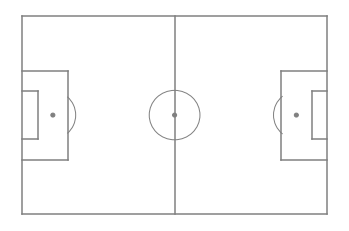

In [15]:
(fig,ax) = createPitch(120,80,'yards','gray')
def getAreasForEachEvent(matchdata, voronoi=True, numPlayersContrast=3, samples=-1, lastPlayerAsBoundary=True):
    areaT1 = list()
    areaT2 = list()
    for sampleNumber, iEvent in enumerate(matchdata.keys()):
        if samples >= sampleNumber:
          break
        voronoiHomeXY = list()
        voronoiAwayXY = list()
        if matchdata[iEvent]['eventLoc'] is not None and len(matchdata[iEvent]['eventLoc']) > 0 and abs(len(matchdata[iEvent]['homeLoc']) - len(matchdata[iEvent]['awayLoc'])) <= numPlayersContrast:
            minX = 120
            maxX = 0
            x = matchdata[iEvent]['eventLoc'][0]
            y = matchdata[iEvent]['eventLoc'][1]
            x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
            minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            for i in range(len(matchdata[iEvent]['homeLoc'])):
                x=matchdata[iEvent]['homeLoc'][i][0]
                y=matchdata[iEvent]['homeLoc'][i][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                voronoiHomeXY.append((x, y, 0))
                minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            for j in range(len(matchdata[iEvent]['awayLoc'])):
                x=matchdata[iEvent]['awayLoc'][j][0]
                y=matchdata[iEvent]['awayLoc'][j][1]
                x = xComplimentPostHalf(x, matchdata[iEvent]['period'])
                voronoiAwayXY.append((x, y, 1))
                minX, maxX = setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary)

            if voronoi == True:
                voronoiDF = pd.DataFrame({'x' : [i[0] for i in voronoiHomeXY] + [i[0] for i in voronoiAwayXY], 
                                          'y' : [i[1] for i in voronoiHomeXY] + [i[1] for i in voronoiAwayXY],
                                          'team' : [i[2] for i in voronoiHomeXY] + [i[2] for i in voronoiAwayXY]})

                pitch = Pitch(pitch_type = 'statsbomb')
                team1, team2 = pitch.voronoi(voronoiDF.x, voronoiDF.y, voronoiDF.team)

                t1 = pitch.polygon(team1, ax=ax, fc='lightskyblue', ec='white', lw=3, alpha=.1)  # likely away
                t2 = pitch.polygon(team2, ax=ax, fc='lightsalmon', ec='white', lw=3, alpha=.1)   # likely home

                xyT1 = list()
                xyT2 = list()
                for iPolygon in t1:
                    xyT1.append([list(iXY) if minX < iXY[0] < maxX else [minX, iXY[1]] if minX > iXY[0] else [maxX, iXY[1]] for iXY in iPolygon.get_xy()])

                for iPolygon in t2:
                    xyT2.append([list(iXY) if minX < iXY[0] < maxX else [minX, iXY[1]] if minX > iXY[0] else [maxX, iXY[1]] for iXY in iPolygon.get_xy()])

                areaT1.append(getTotalAreaFromOneEvent(xyT1))
                areaT2.append(getTotalAreaFromOneEvent(xyT2))

    return areaT1, areaT2


def xComplimentPostHalf(x, period):
    if period == 2 or period == 4:
        x = 120-x
    return x

def setMinXMaxX(minX, maxX, x, lastPlayerAsBoundary):
    if lastPlayerAsBoundary is True:
        if minX > x:
            minX = x
        if maxX < x:
            maxX = x
        return minX, maxX
    else:
        return minX, maxX

def getTotalAreaFromOneEvent(xyT):
    areaPolygon = 0
    for iPolygon in xyT:
        areaPolygon += shapelyPolygon(iPolygon).area
    return areaPolygon

def getMuStd(areaT):
    mu, std = norm.fit(areaT)
    return mu, std

In [16]:
from numpy.ma.extras import average
dfAreas = pd.DataFrame(columns=['Home team', 'Home score', 'Home area mean', 'Home area std', 'Away area std', 'Away area mean', 'Away score', 'Away team', 'Stage', 'Stage Id'])
for iMatchId in matchIDs:
    matchdata = loadJson(iMatchId)
    areaT1, areaT2 = getAreasForEachEvent(matchdata, lastPlayerAsBoundary=False)
    muT1, stdT1 = getMuStd(areaT1) # Likely away
    muT2, stdT2 = getMuStd(areaT2) # Likely home
    homeTeam = event360.matchInfo[iMatchId]['home_team']['home_team_name']
    awayTeam = event360.matchInfo[iMatchId]['away_team']['away_team_name']
    homescore = event360.matchInfo[iMatchId]['home_score']
    awayscore = event360.matchInfo[iMatchId]['away_score']
    stage = event360.matchInfo[iMatchId]['competition_stage']['name']
    stageid = event360.matchInfo[iMatchId]['competition_stage']['id']
    df = pd.DataFrame({'Home team': homeTeam , 'Home score': homescore, 'Home area mean': muT2, 'Home area std': stdT2, 'Away area std': stdT1, 'Away area mean': muT1, 'Away score': awayscore, 'Away team': awayTeam, 'Stage': stage, 'Stage Id': stageid}, index=[0])
    dfAreas = dfAreas.append(df, ignore_index=True)

In [17]:
dfAreas.sort_values(by=['Stage Id'], inplace=True)
dfEnglandAreas = dfAreas[(dfAreas['Home team'] == "England Women's") | (dfAreas['Away team'] == "England Women's" )]
dfEnglandAreas = dfEnglandAreas.drop(['Home area std', 'Away area std', 'Stage Id'], axis=1)

In [19]:
# Swap column values where away team is engalnd to make bar plot
dfEnglandAreas['Home team'], dfEnglandAreas['Home score'], dfEnglandAreas['Home area mean'], dfEnglandAreas['Away team'],dfEnglandAreas['Away score'], dfEnglandAreas['Away area mean'] = np.where(dfEnglandAreas['Away team']=="England Women's", (dfEnglandAreas['Away team'],dfEnglandAreas['Away score'], dfEnglandAreas['Away area mean'], dfEnglandAreas['Home team'],dfEnglandAreas['Home score'], dfEnglandAreas['Home area mean']), (dfEnglandAreas['Home team'], dfEnglandAreas['Home score'], dfEnglandAreas['Home area mean'], dfEnglandAreas['Away team'],dfEnglandAreas['Away score'], dfEnglandAreas['Away area mean']))

In [43]:
def colorGreenOrange(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    default = ''

    # must return one string per cell in this row
    if row['Home score'] > row['Away score']:
        backColor = [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor = [highlight2, highlight1]
    else:
        backColor = [default, default]

    if row['Home area mean'] > row['Away area mean']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfEnglandAreas.style.apply(colorGreenOrange, subset=['Home score', 'Away score', 'Home area mean', 'Away area mean'], axis=1)

,Home team,Home score,Home area mean,Away area mean,Away score,Away team,Stage
20,England Women's,8,5052.742828,3298.827703,0,Norway Women's,Group Stage
30,England Women's,1,4675.191834,3911.227146,0,Austria Women's,Group Stage
2,England Women's,5,3742.199988,4956.305715,0,Northern Ireland,Group Stage
9,England Women's,2,4417.224821,3904.750375,1,Spain Women's,Quarter-finals
1,England Women's,4,4433.660799,4058.862278,0,Sweden Women's,Semi-finals
0,England Women's,2,4200.446970,4271.025164,1,Germany Women's,Final


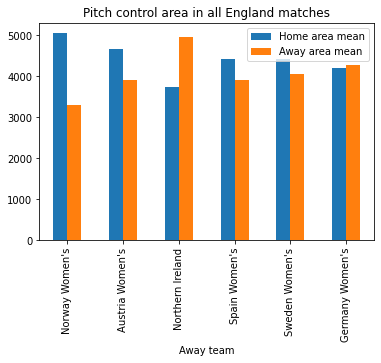

In [20]:
dfEnglandAreas.plot.bar(x='Away team', y=['Home area mean', 'Away area mean'], title='Pitch control area in all England matches').figure.savefig('englandareas.png', bbox_inches='tight')

In [21]:
dfEnglandAreas.drop(['Home area mean', 'Away area mean'], axis=1)

,Home team,Home score,Away score,Away team,Stage
20,England Women's,8,0,Norway Women's,Group Stage
30,England Women's,1,0,Austria Women's,Group Stage
2,England Women's,5,0,Northern Ireland,Group Stage
9,England Women's,2,1,Spain Women's,Quarter-finals
1,England Women's,4,0,Sweden Women's,Semi-finals
0,England Women's,2,1,Germany Women's,Final


# Pressing Calculations

In [22]:
def number_of_events(defObject = event360, defMatchId = 3847567):
    try:
        filename = 'eventTypeDict' + '.json'
        with open(filename, 'r') as fh:
            eventTypeDict = json.load(fh)
        fh.close()
        return eventTypeDict
    except:
        underPressureCounts = 0
        typesCounts = 0
        typesList = list()
        eventTypeDict = dict()
        events = defObject.matchEvents[defMatchId]
        for iEvent in events:
            if 'under_pressure' in events[iEvent].keys():
                underPressureCounts += 1
            if 'type' in events[iEvent].keys():
                if events[iEvent]['type']['name'] not in typesList:
                    print(events[iEvent])
                    eventTypeDict[events[iEvent]['type']['name']] = input()
                    clear_output()
                typesList.append(events[iEvent]['type']['name'])
                typesCounts += 1

        print(len(events))
        print(underPressureCounts)
        print(typesCounts)
        return eventTypeDict

eventTypeDict = number_of_events()
# 0 is same team and 1 is opponent, 2 is ne

In [27]:
def getOtherId(homeId, awayId, currentId):
    if homeId == currentId:
        return awayId
    else:
        return homeId

def updateDict(blueprintDict, homeId, awayId, teamId, keyTeamId, keyOtherId, durationCount, value):
    otherId = getOtherId(homeId, awayId, teamId)
    blueprintDict[teamId][keyTeamId][durationCount] += value
    blueprintDict[otherId][keyOtherId][durationCount] += value
    return blueprintDict

def updateFromDictAtoDictB(dictA, dictB):
    for iKey in dictA.keys():
        for jKey in dictA[iKey].keys():
            for kKey in dictA[iKey][jKey].keys():
                dictA[iKey][jKey][kKey] += dictB[iKey][jKey][kKey]
    return dictA

In [28]:
def getLocationDifference(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    foundNext = False
    pressFailed = False
    dangerXLoc = 0
    dangerYLoc = 40

    if 'location' in events[iEvent].keys():
        currentXLoc, currentYLoc = events[iEvent]['location']
        currentTeamId = events[iEvent]['team']['id']
        currentPeriod = events[iEvent]['period']

    while True:
        foundNext = False
        if iEventIndex < len(list(events.keys())) - 1:
            nextEventId = list(events)[iEventIndex + 1]
            if events[nextEventId]['period'] == currentPeriod:
                if 'location' in events[nextEventId].keys():
                    foundNext = True
                    nextXLoc, nextYLoc = events[nextEventId]['location']
                    nextTeamId = events[nextEventId]['team']['id']
                    if nextTeamId != currentTeamId:
                        nextXLoc = 120 - nextXLoc
                        nextYLoc = 80 - nextYLoc
                    break

                else:
                    iEventIndex += 1
                    continue

            else:
                break

        else:
            break
  
    if foundNext == True:
        currentDist = (currentXLoc - dangerXLoc)**2 + (currentYLoc - dangerYLoc)**2
        nextDist = (nextXLoc - dangerXLoc)**2 + (nextYLoc - dangerYLoc)**2
        if currentDist > nextDist:
            pressFailed = True

    return foundNext, pressFailed

In [29]:
def getPressStatusMiscontrol(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    foundNext = False
    pressFailed = False
    dangerXLoc = 0
    dangerYLoc = 40

    if 'location' in events[iEvent].keys():
        currentTeamId = events[iEvent]['team']['id']
        currentPeriod = events[iEvent]['period']

    while True:
        foundNext = False
        if iEventIndex < len(list(events.keys())) - 1:
            nextEventId = list(events)[iEventIndex + 1]
            if events[nextEventId]['period'] == currentPeriod:
                if 'type' in events[nextEventId].keys() and events[nextEventId]['type']['name'] == 'Pressure':
                    iEventIndex += 1
                    continue

                elif 'type' in events[nextEventId].keys() and events[nextEventId]['type']['name'] == 'Dispossessed':
                    nextTeamId = getOtherId(homeId, awayId, events[nextEventId]['team']['id'])
                    iEventIndex += 1
                    continue

                if 'location' in events[nextEventId].keys():
                    foundNext = True
                    nextTeamId = events[nextEventId]['team']['id']
                    break

                else:
                    iEventIndex += 1
                    continue

            else:
                break

        else:
            break
  
    if foundNext == True:
        if nextTeamId == currentTeamId:
            pressFailed = True

    return foundNext, pressFailed

In [30]:
def checkSameRules(homeId, awayId, iEvent, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == 'Carry':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Ball Receipt*':
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
        
        elif eventTypeName == 'Pass':
            eventTypeName = 'pass' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [9, 75, 76]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        pass        
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Foul Won':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Shot':
            eventTypeName = 'shot' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [96, 98, 101, 115]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1) 
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)        
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        
            else:
              if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                  durationEvent = events[iEvent]['duration']
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
              else:
                  blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)

    return blueprintDict

In [31]:
def checkOppRules(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == 'Clearance':
            foundNext, pressFailed = getLocationDifference(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
            if foundNext is True:
                if pressFailed is True:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
                else:
                    if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                        durationEvent = events[iEvent]['duration']
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)

        elif eventTypeName == 'Miscontrol':
            if eventTypeName in events[iEvent].keys():
                foundNext, pressFailed = getPressStatusMiscontrol(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                if foundNext is True:
                    if pressFailed is True:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)
        
        elif eventTypeName == 'Dispossessed':
            dispossessorId = getOtherId(homeId, awayId, events[iEvent]['team']['id'])
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, dispossessorId, 'failedEvadedPress', 'successPress', 'counts', 1)
            

        elif eventTypeName == 'Foul Committed':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)

        elif eventTypeName == 'Interception':
            eventTypeName = 'interception' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [15, 16, 17, 4]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)   
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

    return blueprintDict

In [32]:
def checkMixRules(homeId, awayId, iEvent, iEventIndex, defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    eventTypeName = events[iEvent]['type']['name']
    underPressure = False

    blueprintDict = dict()
    blueprintDict[homeId] = dict()
    blueprintDict[awayId] = dict()
    blueprintDict[homeId]['successPress'] = dict()
    blueprintDict[homeId]['failedPress'] = dict()
    blueprintDict[homeId]['successEvadedPress'] = dict()
    blueprintDict[homeId]['failedEvadedPress'] = dict()
    blueprintDict[awayId]['successPress'] = dict()
    blueprintDict[awayId]['failedPress'] = dict()
    blueprintDict[awayId]['successEvadedPress'] = dict()
    blueprintDict[awayId]['failedEvadedPress'] = dict()

    blueprintDict[homeId]['successPress']['duration'] = 0
    blueprintDict[homeId]['successPress']['counts'] = 0
    blueprintDict[homeId]['failedPress']['duration'] = 0
    blueprintDict[homeId]['failedPress']['counts'] = 0
    blueprintDict[homeId]['successEvadedPress']['duration'] = 0
    blueprintDict[homeId]['successEvadedPress']['counts'] = 0
    blueprintDict[homeId]['failedEvadedPress']['duration'] = 0
    blueprintDict[homeId]['failedEvadedPress']['counts'] = 0

    blueprintDict[awayId]['successPress']['duration'] = 0
    blueprintDict[awayId]['successPress']['counts'] = 0
    blueprintDict[awayId]['failedPress']['duration'] = 0
    blueprintDict[awayId]['failedPress']['counts'] = 0
    blueprintDict[awayId]['successEvadedPress']['duration'] = 0
    blueprintDict[awayId]['successEvadedPress']['counts'] = 0
    blueprintDict[awayId]['failedEvadedPress']['duration'] = 0
    blueprintDict[awayId]['failedEvadedPress']['counts'] = 0


    if 'under_pressure' in events[iEvent].keys():
        underPressure = True
        if eventTypeName == '50/50':
            eventTypeName = '50-50' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [108, 147]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'counts', 1)     
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

        elif eventTypeName == 'Dribble':
            eventTypeName = 'dribble' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [8]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successEvadedPress', 'failedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)  
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedEvadedPress', 'successPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass
        
        elif eventTypeName == 'Pressure':
            pass            

        elif eventTypeName == 'Ball Recovery':
            if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                durationEvent = events[iEvent]['duration']
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'duration', durationEvent)
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)
            else:
                blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedPress', 'counts', 1)

        elif eventTypeName == 'Duel':
            eventTypeName = 'duel' # because of data
            if eventTypeName in events[iEvent].keys():
                if 'outcome' in events[iEvent][eventTypeName]:
                    if events[iEvent][eventTypeName]['outcome']['id'] in [4, 15, 16, 17]:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'successPress', 'failedEvadedPress', 'counts', 1)
                    else:
                        if 'duration' in events[iEvent].keys() and events[iEvent]['duration'] > 0:
                            durationEvent = events[iEvent]['duration']
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'duration', durationEvent)
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)  
                        else:
                            blueprintDict = updateDict(blueprintDict, homeId, awayId, events[iEvent]['team']['id'], 'failedPress', 'successEvadedPress', 'counts', 1)        
                else:
                    pass
                        
            else:
              pass

    return blueprintDict

In [33]:
def getPressStatsFn(defObject = event360, defMatchId = 3847567, eventTypeDict = eventTypeDict):
    events = defObject.matchEvents[defMatchId]
    homeId = defObject.matchInfo[defMatchId]['home_team']['home_team_id']
    awayId = defObject.matchInfo[defMatchId]['away_team']['away_team_id']
    
    getPressStats = dict()
    getPressStats[homeId] = dict()   # Home team id
    getPressStats[awayId] = dict()   # Away team id

    getPressStats[homeId]['successPress'] = dict()
    getPressStats[homeId]['failedPress'] = dict()
    getPressStats[homeId]['successEvadedPress'] = dict()
    getPressStats[homeId]['failedEvadedPress'] = dict()
    getPressStats[awayId]['successPress'] = dict()
    getPressStats[awayId]['failedPress'] = dict()
    getPressStats[awayId]['successEvadedPress'] = dict()
    getPressStats[awayId]['failedEvadedPress'] = dict()

    getPressStats[homeId]['successPress']['duration'] = 0
    getPressStats[homeId]['successPress']['counts'] = 0
    getPressStats[homeId]['failedPress']['duration'] = 0
    getPressStats[homeId]['failedPress']['counts'] = 0
    getPressStats[homeId]['successEvadedPress']['duration'] = 0
    getPressStats[homeId]['successEvadedPress']['counts'] = 0
    getPressStats[homeId]['failedEvadedPress']['duration'] = 0
    getPressStats[homeId]['failedEvadedPress']['counts'] = 0

    getPressStats[awayId]['successPress']['duration'] = 0
    getPressStats[awayId]['successPress']['counts'] = 0
    getPressStats[awayId]['failedPress']['duration'] = 0
    getPressStats[awayId]['failedPress']['counts'] = 0
    getPressStats[awayId]['successEvadedPress']['duration'] = 0
    getPressStats[awayId]['successEvadedPress']['counts'] = 0
    getPressStats[awayId]['failedEvadedPress']['duration'] = 0
    getPressStats[awayId]['failedEvadedPress']['counts'] = 0


    eventCounter = 0
    for iEventIndex, iEvent in enumerate(events):
        if 'type' in events[iEvent].keys():
            # skip the neutral type
            eventTypeName = events[iEvent]['type']['name']
            if eventTypeName in eventTypeDict.keys():
                if eventTypeDict[eventTypeName] == 'Neutral':
                    continue
                elif eventTypeDict[eventTypeName] == 'Same':
                    someDict = checkSameRules(homeId, awayId, iEvent, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                elif eventTypeDict[eventTypeName] == 'Opp':
                    someDict = checkOppRules(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                elif eventTypeDict[eventTypeName] == 'Mix':
                    someDict = checkMixRules(homeId, awayId, iEvent, iEventIndex, defObject, defMatchId, eventTypeDict)
                    getPressStats = updateFromDictAtoDictB(getPressStats, someDict.copy())
                else:
                    continue


    getPressStats[homeId]['teamname'] = defObject.matchInfo[defMatchId]['home_team']['home_team_name']
    getPressStats[awayId]['teamname'] = defObject.matchInfo[defMatchId]['away_team']['away_team_name']
    return getPressStats[homeId]['successEvadedPress']['duration'] + getPressStats[homeId]['successPress']['duration'], getPressStats[awayId]['successEvadedPress']['duration'] + getPressStats[awayId]['successPress']['duration'], getPressStats[homeId]['successEvadedPress']['counts'] + getPressStats[homeId]['successPress']['counts'], getPressStats[awayId]['successEvadedPress']['counts'] + getPressStats[homeId]['successPress']['counts']

#getPressStats = getPressStatsFn()

In [34]:
matchIDs = [int(iFile.split('.')[0]) for iFile in os.listdir(os.getcwd()) if 'json' in iFile and iFile[0].isnumeric()]
dfPress = pd.DataFrame(columns=['Home team', 'Home score', 'Home success evaded press', 'Home success press counts', 'Away success press counts', 'Away success evaded press', 'Away score', 'Away team', 'Stage', 'Stage Id'])
for iMatchId in matchIDs:
    matchdata = loadJson(iMatchId)
    homeSuccessEvaded, awaySuccessEvaded, homeSuccessEvadedCounts, awaySuccessEvadedCounts = getPressStatsFn(defMatchId = iMatchId)
    homeSuccessEvaded = round(homeSuccessEvaded, 4)
    awaySuccessEvaded = round(awaySuccessEvaded, 4)
    homeTeam = event360.matchInfo[iMatchId]['home_team']['home_team_name']
    awayTeam = event360.matchInfo[iMatchId]['away_team']['away_team_name']
    homescore = event360.matchInfo[iMatchId]['home_score']
    awayscore = event360.matchInfo[iMatchId]['away_score']
    stage = event360.matchInfo[iMatchId]['competition_stage']['name']
    stageid = event360.matchInfo[iMatchId]['competition_stage']['id']
    df = pd.DataFrame({'Home team': homeTeam , 'Home score': homescore, 'Home success evaded press': homeSuccessEvaded, 'Home success press counts': homeSuccessEvadedCounts, 'Away success press counts': awaySuccessEvadedCounts, 'Away success evaded press': awaySuccessEvaded, 'Away score': awayscore, 'Away team': awayTeam, 'Stage': stage, 'Stage Id': stageid}, index=[0])
    dfPress = dfPress.append(df, ignore_index=True)

In [37]:
dfPress.sort_values(by=['Stage Id'], inplace=True)
dfEnglandPress = dfPress[(dfPress['Home team'] == "England Women's") | (dfPress['Away team'] == "England Women's" )]
dfEnglandPress = dfEnglandPress.drop([ 'Home success evaded press',  'Away success evaded press', 'Stage Id'], axis=1)

In [40]:
# Swap column values where away team is engalnd to make bar plot
dfEnglandPress['Home team'], dfEnglandPress['Home score'], dfEnglandPress['Home success press counts'], dfEnglandPress['Away team'],dfEnglandPress['Away score'], dfEnglandPress['Away success press counts'] = np.where(dfEnglandPress['Away team']=="England Women's", (dfEnglandPress['Away team'],dfEnglandPress['Away score'], dfEnglandPress['Away success press counts'], dfEnglandPress['Home team'],dfEnglandPress['Home score'], dfEnglandPress['Home success press counts']), (dfEnglandPress['Home team'], dfEnglandPress['Home score'], dfEnglandPress['Home success press counts'], dfEnglandPress['Away team'],dfEnglandPress['Away score'], dfEnglandPress['Away success press counts']))

In [45]:
dfEnglandPress = dfEnglandPress.rename(columns={'Home success press counts': 'Home press counts',  'Away success press counts': 'Away press counts'})

In [46]:
def colorGreenOrangePress(row):    

    highlight1 = 'background-color: green;'
    highlight2 = 'background-color: orange;'
    default = ''

    # must return one string per cell in this row
    if row['Home score'] > row['Away score']:
        backColor = [highlight1, highlight2]
    elif row['Home score'] < row['Away score']:
        backColor = [highlight2, highlight1]
    else:
        backColor = [default, default]

    if row['Home press counts'] > row['Away press counts']:
        backColor += [highlight1, highlight2]
    else:
        backColor += [highlight2, highlight1]
    
    return backColor

dfEnglandPress.style.apply(colorGreenOrangePress, subset=['Home score', 'Away score', 'Home press counts', 'Away press counts'], axis=1)

,Home team,Home score,Home press counts,Away press counts,Away score,Away team,Stage
20,England Women's,8,304,164,0,Norway Women's,Group Stage
30,England Women's,1,315,275,0,Austria Women's,Group Stage
2,England Women's,5,334,163,0,Northern Ireland,Group Stage
9,England Women's,2,345,436,1,Spain Women's,Quarter-finals
1,England Women's,4,378,294,0,Sweden Women's,Semi-finals
0,England Women's,2,399,385,1,Germany Women's,Final


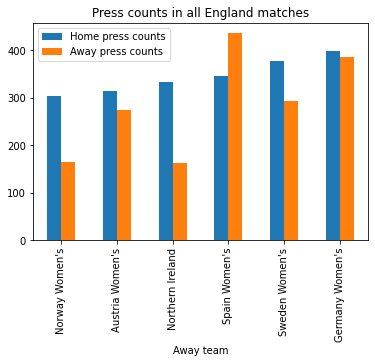

In [47]:
dfEnglandPress.plot.bar(x='Away team', y=['Home press counts', 'Away press counts'], title='Press counts in all England matches').figure.savefig('englandpress.png', bbox_inches='tight')